In [110]:
# open the neighbourhood GRB pickled file
with open('data/nbd_array', 'rb') as f:
    nbd = pickle.load(f)

Comparing the GRB's :

`(2, [6,17,23])`

2 = GRB141205018  ; this is the center 

6 = GRB150312403

17 = GRB170130697

23 = GRB220415645

In [115]:
# get the ra and dec values of grbs to compare
lcdf = pd.read_csv('data/gbmdatacleaned.csv', index_col=0) # light curve data frame

grb_index = nbd[7][1].copy() # copy neighborhood indices list
grb_index.insert(0, nbd[7][0]) # insert the center index at 0th pos
print(grb_index)

# ra-dec, name of selected grbs
ra = [] 
dec = [] 
grbnames = [] 
for i in grb_index:
    ra.append(lcdf.iloc[i].ra_val)
    dec.append(lcdf.iloc[i].dec_val)
    grbnames.append(lcdf.name.iloc[i])

grbnumbers = [x[3:] for x in grbnames] # GRB number

[10, 13, 26]


In [116]:
grbt90 = [lc.get_t90(name) for name in grbnames] # t90's
grbbinsize = [lc.binsize(t90) for t90 in grbt90] # bin sizes

In [118]:
# find the name of the brightest NaI detector

detectors = [] # brightest detector name
for i in range(len(grb_index)):
    # try suffix _v01 or _v00
    try:
        b = esad.angle_to_grb(ra[i],
                          dec[i],
                          '/Users/dimrisudhanshu/Downloads/current/glg_trigdat_all_bn' + grbnumbers[i] + '_v01.fit')
    except:
        b = esad.angle_to_grb(ra[i],
                          dec[i],
                          '/Users/dimrisudhanshu/Downloads/current/glg_trigdat_all_bn' + grbnumbers[i] + '_v02.fit')
    detectors.append(b[0])

detectors

['n8', 'n8', 'n9']

In [119]:
# open the fits file corresponding to the brightest NaI detectors
fitfiles = []
for i in range(len(grb_index)):
    try:
        fitfile = fits.open('/Users/dimrisudhanshu/Downloads/current/glg_tte_' + detectors[i] + '_bn' + grbnumbers[i] + '_v00.fit')
    except:
        fitfile = fits.open('/Users/dimrisudhanshu/Downloads/current/glg_tte_' + detectors[i] + '_bn' + grbnumbers[i] + '_v01.fit')
    
    fitfiles.append(fitfile)

DTW : 0.0
DTW : 57991.0
DTW : 23236.0


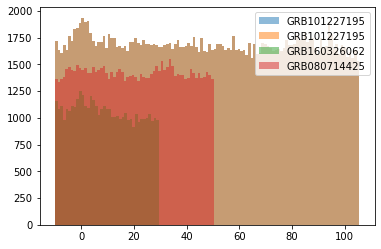

In [120]:
referenceLC = lc.getLightCurve(fitfiles[0]) # reference fit file
ref_name = fitfiles[0][0].header['OBJECT'] # GRB name of reference
distance_list = [] # for DTW distances
for fitfile in fitfiles:
    targetLC = lc.getLightCurve(fitfile) # target fit file
    tar_name = fitfile[0].header['OBJECT'] # GRB name of target
    d = lc.getDTW(referenceLC, targetLC, ref_name, tar_name) # get DTW distance
    distance_list.append(d)
    print(f'DTW : {d}')

In [121]:
def simulate(fitfile, num, size = 0):
    '''
    function to simulate light curves with poisson distribution
    fitfile = GRB to simulate
    size = binsize of GRB
    num = number of simulated curves
    '''
    reference = lc.getLightCurve(fitfile, size)
    simcurves = [] # for simulated curves
    for i in range(num):
        curve = []
        for n in reference:
            curve.append(poisson.rvs(mu = n, size = 1)[0])
        simcurves.append(curve)
    
    return simcurves

Total time = 10.03177809715271


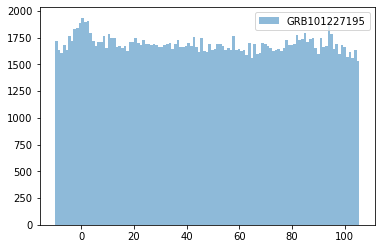

In [122]:
start_time = time.time()

simulated_curves = simulate(fitfiles[0], 100)
dtw_list = []
for curve in simulated_curves:
    d = lc.getDTW(referenceLC, curve, '', '')
    dtw_list.append(d)
    
end_time = time.time()

print(f'Total time = {end_time - start_time}')

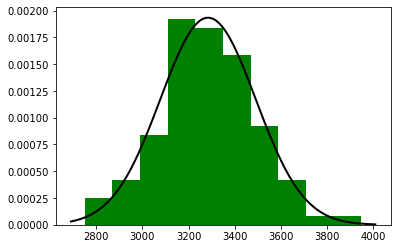

In [123]:
# mean and standard deviation of simulated dtw distance
mu, std = norm.fit(dtw_list)

# plot hist + normal distribution
plt.hist(dtw_list, density=True, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# dtw distance of target curves
# for x in distance_list:
#     plt.axvline(x)

# number of stdev away from mean
stddev = []
for d in distance_list:
    stddev.append((abs(mu - d))/std)

# for x, y in zip(distance_list, stddev):
#     if y <= 10:
#         plt.axvline(x)

In [124]:
isref = [1] + [0] * (len(grbnames) - 1)

In [127]:
datadf1 = pd.read_csv('data/distance_dat_file.csv')

datadf = pd.DataFrame({'Index':grb_index, 'Is Reference': isref, 'Name':grbnames, 'Number':grbnumbers,
                       'Brightest Detector':detectors, 'ra': ra, 'dec':dec,
                       't90':grbt90, 'Binsize':grbbinsize, 'Distance':distance_list,
                       'Sigma':stddev})

In [128]:
datadf.head()

,Index,Is Reference,Name,Number,Brightest Detector,ra,dec,t90,Binsize,Distance,Sigma
0,10,1,GRB101227195,101227195,n8,186.79,-83.55,95.488,1,0.0,15.919308
1,13,0,GRB160326062,160326062,n8,188.15,-82.69,19.456,1,57991.0,265.164198
2,26,0,GRB080714425,080714425,n9,187.50,-74.00,40.192,1,23236.0,96.706036


In [125]:
new_datadf = pd.concat([datadf1, datadf]).reset_index(drop=True)

new_datadf.to_csv('data/distance_dat_file.csv', index=False)

In [126]:
nbd[:10]

[(0, [3]),
 (2, [6, 17, 23]),
 (3, [12]),
 (4, [7]),
 (5, [6]),
 (7, [34]),
 (8, [11, 29]),
 (10, [13, 26]),
 (11, [27, 29, 50]),
 (12, [16, 28])]

In [108]:
# get the ra and dec values of grbs to compare
lcdf = pd.read_csv('data/gbmdatacleaned.csv', index_col=0) # light curve data frame

for x in nbd[:10]:
    grb_index = x[1].copy() # copy neighborhood indices list
    grb_index.insert(0, x[0]) # insert the center index at 0th pos
    # print(grb_index)

    # ra-dec, name of selected grbs
    ra = [] 
    dec = [] 
    grbnames = [] 
    for i in grb_index:
        ra.append(lcdf.iloc[i].ra_val)
        dec.append(lcdf.iloc[i].dec_val)
        grbnames.append(lcdf.name.iloc[i])

    grbnumbers = [x[3:] for x in grbnames] # GRB number
    print(grbnumbers)

['120403857', '180630467']
['141205018', '150312403', '170130697', '220415645']
['180630467', '200607921']
['170116238', '110520302']
['091026550', '150312403']
['110520302', '101024486']
['121216419', '220430900', '171206122']
['101227195', '160326062', '080714425']
['220430900', '100507577', '171206122', '170121067']
['200607921', '101116481', '200907957']
